# Google maps API

### 1 Load credentials
### 2 get/ load Google Maps API data
### 3 process Gmaps data into tables
### 4 load & process map data (plitical borders....)
### 5 combine Gmaps and municipality data
### 6 plots

 

In [25]:
import yaml
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle as pk


from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
from pandas.io.json import json_normalize
from time import sleep
from scipy.spatial.distance import cdist

## 1 Load credentials

In [26]:
#loading credentials
key_yaml = yaml.load(open('credentials.yml'), Loader=yaml.FullLoader)

## 2 get/ load Google Maps API data

In [276]:
def getAPIContent(url):
    """
    API acces wrapper 
    """
    req = requests.get(url)
    places_json = req.json()
    return {key: places_json[key] for key in places_json.keys() & {'results', 'next_page_token'}}


def get60Locations(searchquery, max_steps = 5):
    """
    automate multi-page API queries
    """

    url = "https://maps.googleapis.com/maps/api/place/textsearch/json?" #just for places API

    # The text string on which to search 
    query = 'query=' + searchquery

    AllResults = {}
    next_page_token = 'startstring'
    step = 0

    #loop as long next_page_token is not empty or max steps is reached
    while bool(next_page_token) & (step < max_steps):
        print('iteration {} of query {}'.format(step,searchquery))
        #print(f'We are in loop nr {step}')
        AllResults[step] = getAPIContent(url + query + '&key=' + key_yaml['key_api'])
        if 'next_page_token' in AllResults[step].keys():
            #print(AllResults[step]['next_page_token'])
            next_page_token = AllResults[step]['next_page_token']
        else: #break in case there is no next_page_token
            next_page_token = '' 

        query = 'pagetoken=' + next_page_token
        #print(f'The current next_page_token is {next_page_token}')
        #print('Next url is:')
        #print(url + query + '&key=' + key_yaml['key_api'])

        #increment step
        step += 1
        sleep(2)
    
    return AllResults

def latlon2m(lat,lon,lat_0=47.37174,lon_0=8.54226):
    """
    converts a place of lat, lon into meters, relative to a zero reference
    """
    lat=np.array(lat)
    lon=np.array(lon)
    r_earth=6.3781e6 
    ang=np.deg2rad([lat,lon])
    ref=np.deg2rad([lat_0,lon_0])
    
    north=(ang[0]-ref[0])*r_earth
    west=(ang[1]-ref[1])*r_earth*np.cos(ang[0])
    dist=np.sqrt(np.power(north,2)+np.power(west,2))
    
    return (west,north,dist)

def APIdata2DataFrame(Results):
    """
    Takes the results from the get60Locations and puts them into a nice DataFraem
    """
    # merge the multile request results
    df=pd.concat([ pd.DataFrame(Results[x]['results']) for x in range(len(Results)) ],
                 axis=0,sort=False).reset_index(drop=True)

    # remove non-swiss results
    indexNames = df[ df['formatted_address'].str.contains('Switzerland')==False ].index
    if len(indexNames)>0:
        df.drop(indexNames , inplace=True) # prevent error by drop([])
        df.reset_index(drop=True)

    # extract geolocation infos
    df=df.join(json_normalize(df.geometry))

    # extract the postCode
    df=df.join(df.formatted_address.str.extract(r'(\d{4,4})').rename(columns={0: "Postcode"}).astype(int))
    
    # extract the euclidian locations and distances
    df['x']=[latlon2m(x['location.lat'],x['location.lng'])[0] for idx ,x in df.loc[:,['location.lat','location.lng']].iterrows()]
    df['y']=[latlon2m(x['location.lat'],x['location.lng'])[1] for idx ,x in df.loc[:,['location.lat','location.lng']].iterrows()]
    df['distance']=[latlon2m(x['location.lat'],x['location.lng'])[2] for idx ,x in df.loc[:,['location.lat','location.lng']].iterrows()]
    
    return df
    

In [27]:
#fetch data
pfile='save.pickle' # local file to save API results
shops=['Migros','Coop','Denner','Aldi','Lidl','Spar','Volg']
ShoppingGuide_raw=[]
# for idx,shop in enumerate(shops):
#     ShoppingGuide_raw.append(get60Locations(shop))
    
# pk.dump( ShoppingGuide_raw, open(pfile, "wb" ) )  # save to hard disk
ShoppingGuide_raw = pk.load( open( pfile, "rb" ))


## 3 process GMaps data into tables

In [277]:
#making DataFrames
shoppingGuide={x: APIdata2DataFrame(ShoppingGuide_raw[idx]) for idx,x in enumerate(shops)}

### 4 load map data (plitical borders....)

In [343]:
# get gemeindegrenzen data
gfile='../data/sod.sd_quartierteams.json'
with open(gfile) as json_file:
    data = json.load(json_file)
dfg=pd.read_json(gfile)  
# some data wrangling
borders=dfg['features'].apply(pd.Series)['geometry'].apply(pd.Series).iloc[:,1]

#convert to meters
borders=[[[latlon2m(x,y)[0:2] for [y,x] in borders[j][0]]] for j in range(len(borders))]



### 5 combine Gmaps and municipality data

In [282]:
# caclulate gridded data
xrange=[-9000,9000]    #grid range
yrange=[-7000,7000]

n_grid = [1000,1000] # number of grid points
xgrid=np.linspace(xrange[0],xrange[1],n_grid[0])
ygrid=np.linspace(yrange[0],yrange[1],n_grid[1])

[xx,yy]=np.meshgrid(xgrid,ygrid) # make 2d-grid

x2=np.reshape(xx,[np.prod(xx.shape)]) # flatten for cdist function
y2=np.reshape(yy,[np.prod(yy.shape)])


# calculate distances to shops
dists={}
closest={}
for idx, shop in enumerate(shops):
    print(f'{idx}/{len(shops)-1}',shop)
    shopCoords=shoppingGuide[shop][['x','y']].values


    # This solution is optimal when xy2 is very large
    tree = spatial.cKDTree(shopCoords)
    mindist, minid = tree.query(np.array([ ( x, y ) for x, y in zip(x2,y2)]) )
    dists[shop]=np.reshape(mindist,xx.shape)
    closest[shop]=np.reshape(minid,xx.shape)
print('Done calculating distances')

vectors=[]
for idx, shop in enumerate(shops):
    print(f'{idx}/{len(shops)-1}',shop)
    vectors.append([[x,y,d,idx] for  x, y, d, idx in zip(x2,
                                                         y2,
                                                         np.reshape(dists[shop],[np.prod(yy.shape)]),
                                                         np.reshape(closest[shop],[np.prod(yy.shape)]))], )
vectors=np.array(vectors)
print('Done array-ifying into shape')

0/6 Migros
1/6 Coop
2/6 Denner
3/6 Aldi
4/6 Lidl
5/6 Spar
6/6 Volg
Done calculating distances
0/6 Migros
1/6 Coop
2/6 Denner
3/6 Aldi
4/6 Lidl
5/6 Spar
6/6 Volg
Done array-ifying into shape


In [283]:
shoppingGuide['Migros'].head(2)

,formatted_address,geometry,icon,id,name,opening_hours,photos,place_id,plus_code,rating,...,location.lat,location.lng,viewport.northeast.lat,viewport.northeast.lng,viewport.southwest.lat,viewport.southwest.lng,Postcode,x,y,distance
0,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3782609, 'lng': 8.5402...",https://maps.gstatic.com/mapfiles/place_api/ic...,6f898df83ae1b603a902ccad260df28097036819,Migros Supermarkt,{'open_now': True},"[{'height': 3004, 'html_attributions': ['<a hr...",ChIJS6CT8QgKkEcRwqhtQkVOTUI,"{'compound_code': '9GHR+84 Zürich', 'global_co...",4.2,...,47.378261,8.540276,47.379774,8.541851,47.377074,8.539151,8001,-149.576804,725.899057,741.149553
1,"Löwenstrasse 31-35, 8001 Zürich, Switzerland","{'location': {'lat': 47.3753409, 'lng': 8.5363...",https://maps.gstatic.com/mapfiles/place_api/ic...,f209f93c6e8769412c024c8dc57e40daebb0a32a,Migros,{'open_now': False},"[{'height': 1920, 'html_attributions': ['<a hr...",ChIJebvE0AUKkEcRli-dLu8vFaM,"{'compound_code': '9GGP+4G Zürich', 'global_co...",4.3,...,47.375341,8.536346,47.376637,8.537812,47.373937,8.535112,8001,-445.815273,400.848029,599.525145


In [284]:
vectors[0,0,:]

array([-9000.        , -7000.        ,  5165.30197435,    52.        ])

### 5 plots

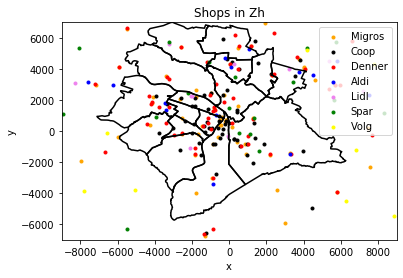

In [365]:
def plotBorders(ax,borders):
    """
    encapsulated the plotting of the political community borders
    """
    borderdata=[]
    for i in range(len(borders)):
        borderdata.append(np.array(borders[i][0]))
        ax.plot(borderdata[i][:,0],
                borderdata[i][:,1],
                c='k')

# plot shops    
colors=['orange','black','red','blue','violet','green','yellow']

fig, ax = plt.subplots()
for idx, shop in enumerate(shops):
    ax.scatter(shoppingGuide[shop]['x'],
               shoppingGuide[shop]['y'], 
               marker='.',
               c=colors[idx],
               label=shop)

ax.set(xlabel='x', ylabel='y',
           title='Shops in Zh')

plt.xlim(-9000, 9000)
plt.ylim(-7000, 7000)

# Gemeindegrenzen
plotBorders(ax,borders)

# ax.grid()
ax.legend()
plt.show()

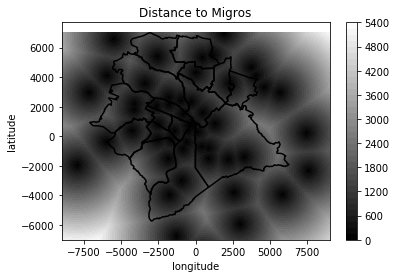

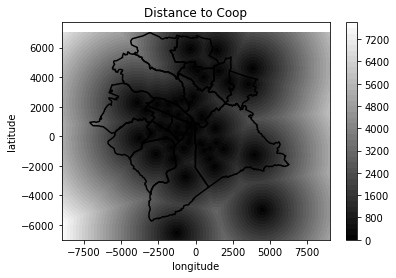

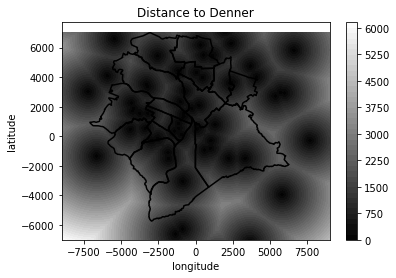

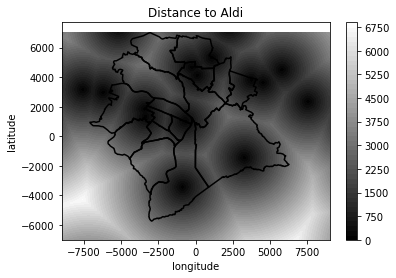

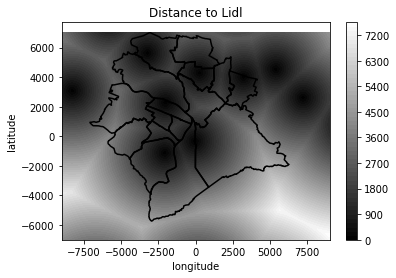

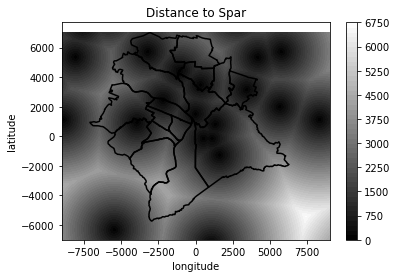

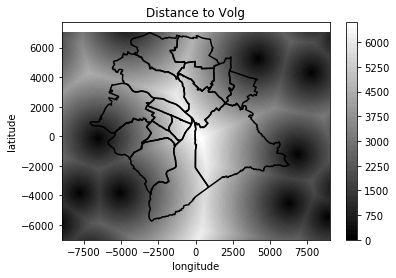

In [345]:
for idx, shop in enumerate(shops):
    fig,ax = plt.subplots()
    p=ax.contourf(xx, yy, dists[shop], 50,cmap='gray')
    cbar = fig.colorbar(p)
    #ax.contourf(xx, yy, closest[shop], 50,cmap='gray')
    # im = ax.imshow(Z, interpolation='bilinear', cmap='hsv',
    #                origin='lower', 
    #               )# vmax=abs(Z).max(), vmin=-abs(Z).max()
    plotBorders(ax,borders)
    ax.set(xlabel='longitude', ylabel='latitude',
           title=f'Distance to {shop}')
    plt.show()

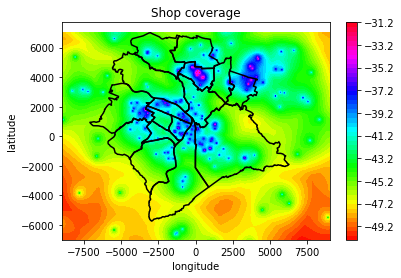

In [364]:
distprod=np.ones(xx.shape)

for idx, shop in enumerate(shops):
    if idx > 0:
        distprod=np.multiply(distprod,dists[shop])
    
    
fig,ax = plt.subplots()
p=ax.contourf(xx, yy, -np.log(distprod), 50,cmap='hsv')
# im = ax.imshow(Z, interpolation='bilinear', cmap='hsv',
#                origin='lower', 
#               )# vmax=abs(Z).max(), vmin=-abs(Z).max()
plotBorders(ax,borders)
ax.set(xlabel='longitude', ylabel='latitude',
       title='Shop coverage')
cbar = fig.colorbar(p)

plt.show()

## transforming latitude/ longitude into swiss system


In [185]:
def world2SwissCoord(lon,lat):
    """
    
    Transforms GPS data (longitude : latitude) into the swiss LV95 System
    lon: longitude (~8.xx for zurich)
    lat: latitude (~47.xx for zurich)
    
    returns:
    x : ost (LV03)
    y : nord (LV03)
    E : ost (LV95)
    N : nord (LV95)
    
    source: https://www.swisstopo.admin.ch/content/swisstopo-internet/de/online/calculation-services/_jcr_content/contentPar/tabs/items/dokumente_und_publik/tabPar/downloadlist/downloadItems/8_1467103085694.download/refsys_d.pdf
    """
    raise('this function is a fail, it wont work')
    # aux parameters
    #φ' = (φ – 169028.66 ")/10000
    #λ' = (λ – 26782.5 ")/10000
    
    
    lam=(lon - 26782.5)/10000
    phi=(lat - 169028.66)/10000
    print(lam,phi)
    
        
#     E [m] = 2600072.37
#     + 211455.93 * λ'
#     - 10938.51 * λ' * φ'
#     - 0.36 * λ' * φ'2
#     - 44.54 * λ'3
#     y [m] = E – 2000000.00
#     N [m] = 1200147.07
#     + 308807.95 * φ'
#     + 3745.25 * λ'2
#     + 76.63 * φ'2
#     - 194.56 * λ'2 * φ'
#     + 119.79 * φ'3
#     x [m] = N – 1000000.00
    
    E = 2600072.37 + 211455.93 * lam - 10938.51 * lam *phi - 0.36 * lam * phi**2 - 44.54 * lam**3
    y = E - 2000000.00
    N = 1200147.07  + 308807.95 *phi  + 3745.25 * lam**2  + 76.63 *phi**2  - 194.56 * lam**2 *phi  + 119.79 *phi**3
    x = N - 1000000.00
    return (x,y,E,N)



In [250]:
shoppingGuide['Migros']['distance']=[latlon2m(x['location.lat'],x['location.lng']) for idx ,x in shoppingGuide['Migros'].loc[:,['location.lat','location.lng']].iterrows()]


In [347]:
shoppingGuide['Migros'].head(2)

,formatted_address,geometry,icon,id,name,opening_hours,photos,place_id,plus_code,rating,...,location.lat,location.lng,viewport.northeast.lat,viewport.northeast.lng,viewport.southwest.lat,viewport.southwest.lng,Postcode,x,y,distance
0,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3782609, 'lng': 8.5402...",https://maps.gstatic.com/mapfiles/place_api/ic...,6f898df83ae1b603a902ccad260df28097036819,Migros Supermarkt,{'open_now': True},"[{'height': 3004, 'html_attributions': ['<a hr...",ChIJS6CT8QgKkEcRwqhtQkVOTUI,"{'compound_code': '9GHR+84 Zürich', 'global_co...",4.2,...,47.378261,8.540276,47.379774,8.541851,47.377074,8.539151,8001,-149.576804,725.899057,741.149553
1,"Löwenstrasse 31-35, 8001 Zürich, Switzerland","{'location': {'lat': 47.3753409, 'lng': 8.5363...",https://maps.gstatic.com/mapfiles/place_api/ic...,f209f93c6e8769412c024c8dc57e40daebb0a32a,Migros,{'open_now': False},"[{'height': 1920, 'html_attributions': ['<a hr...",ChIJebvE0AUKkEcRli-dLu8vFaM,"{'compound_code': '9GGP+4G Zürich', 'global_co...",4.3,...,47.375341,8.536346,47.376637,8.537812,47.373937,8.535112,8001,-445.815273,400.848029,599.525145


0 Coop


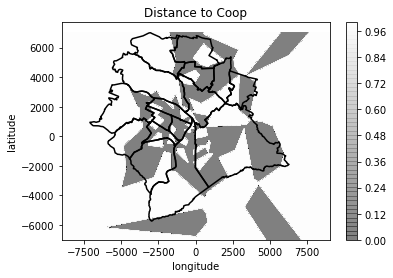

1 Denner


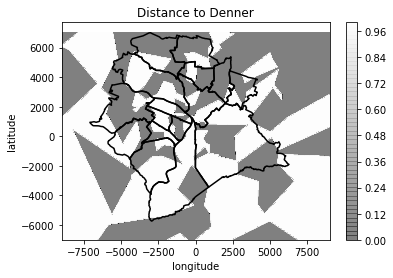

2 Aldi


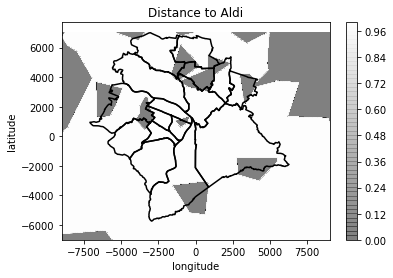

3 Lidl


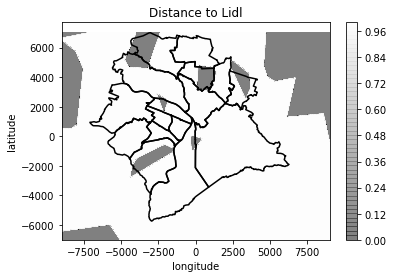

4 Spar


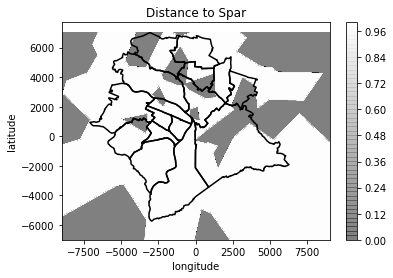

5 Volg


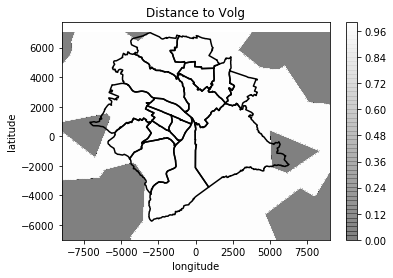

In [348]:
for idx, shop in enumerate(shops[1:]):
    print(idx,shop)
    fig,ax = plt.subplots()
    
    plotdata=((vectors[0,:,2]-vectors[idx+1,:,2])<0).reshape(xx.shape)
    p=ax.contourf(xx, yy, plotdata, 50,cmap='gray',alpha=0.5)
    cbar = fig.colorbar(p)
    #ax.contourf(xx, yy, closest[shop], 50,cmap='gray')
    # im = ax.imshow(Z, interpolation='bilinear', cmap='hsv',
    #                origin='lower', 
    #               )# vmax=abs(Z).max(), vmin=-abs(Z).max()
    plotBorders(ax,borders)
    ax.set(xlabel='longitude', ylabel='latitude',
           title=f'Distance to {shop}')
    plt.show()

0 Coop


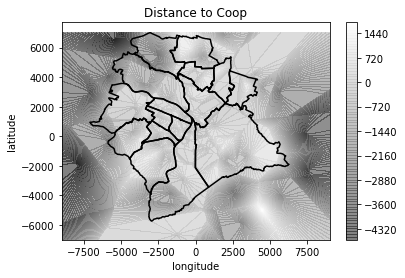

1 Denner


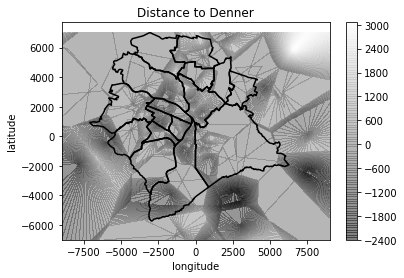

2 Aldi


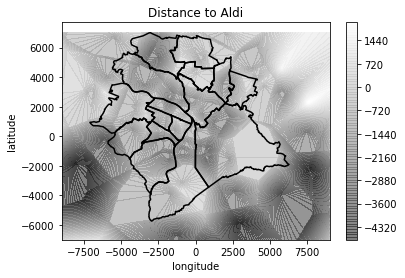

3 Lidl


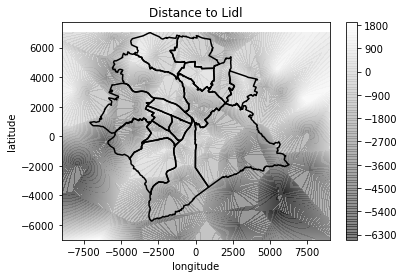

4 Spar


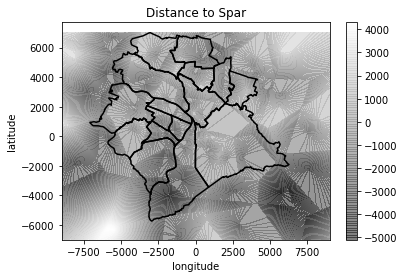

5 Volg


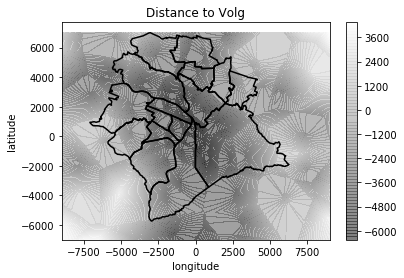

In [356]:
for idx, shop in enumerate(shops[1:]):
    print(idx,shop)
    fig,ax = plt.subplots()
    
    plotdata=((vectors[0,:,2]-vectors[idx+1,:,2])).reshape(xx.shape)
    p=ax.contourf(xx, yy, plotdata, 100,cmap='gray',alpha=0.5)
    cbar = fig.colorbar(p)
    #ax.contourf(xx, yy, closest[shop], 50,cmap='gray')
    # im = ax.imshow(Z, interpolation='bilinear', cmap='hsv',
    #                origin='lower', 
    #               )# vmax=abs(Z).max(), vmin=-abs(Z).max()
    plotBorders(ax,borders)
    ax.set(xlabel='longitude', ylabel='latitude',
           title=f'Distance to {shop}')
    plt.show()

In [349]:
vectors[0,0]

array([-9000.        , -7000.        ,  5165.30197435,    52.        ])

In [272]:
np.power(north,west)

array([1, 4])

In [ ]:
msize=newMigros3['score'].values